### Vi prøver igen ...

I denne model har jeg strengt opdelt i "train" og "test" data. Den forrige model var forkert på en eller anden måde. Alt ser rigtigt ud, men den nåede 100% korrektned straks. Det er meget mistænkeligt, men jeg slet ikke se fejlen. Derfor laver jeg modellen igen med en stræng opdeling. 

Her viser det sig, at modellen er ret ringe til at forudsige antal stragegilinjer ud fra den skrevne tekst. Men det er også en svær disciplin. Det handler om at finde de 2% af linjerne, hvor der er noget stort. Det er en slags "abnormality detection".

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. OG den timsvarende omsættelse til rådata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)


In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')
os.listdir()

['.ipynb_checkpoints',
 'FEDData.xlsx',
 'FEDData_All_texts.xlsx',
 'FEDData_test.xlsx',
 'FEDData_train.xlsx',
 'FEDentry.GIF',
 'FEDentry2.GIF',
 'FED_01_FirstModel.ipynb',
 'FED_02_SplitTrainOgTest.ipynb',
 '~$FEDData_test.xlsx']

Først laver vi en "dictionary", som omsætter ord til tal. Den bruges efterfølgende til at omsætte train data og test data.

In [2]:
# filen med tekster åbnes og indlæses
file = 'FEDData_All_texts.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')

# strenge læses over i en tabel
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# henter text processing modul
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som igen kan laves til en "one-hot)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# en funktion som lave en one-hot vektorer
def vectorize_sequences(sequences, dimension=10000):
    # lave en all-zero matrix af formen (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [4]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDData_train.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')
texts  = df.loc[:,'FEDtext']
labels = df.loc[:,'FEDsize']
texts  = texts.values
labels = labels.values

# ord laves til og der "paddes"
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

# One-hot training data
data = vectorize_sequences(data, dimension=max_words)

# labels laves til vektor
labels = np.asarray(labels).astype('float32')

In [5]:
print(data.shape)
print(labels.shape)

(19961, 10000)
(19961,)


In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(data, labels,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2)

Train on 15968 samples, validate on 3993 samples
Epoch 1/20
15968/15968 [==============================] - 4s 260us/step - loss: 0.5041 - acc: 0.9446 - val_loss: 0.3363 - val_acc: 0.9837
Epoch 2/20
15968/15968 [==============================] - 2s 123us/step - loss: 0.2881 - acc: 0.9776 - val_loss: 0.1765 - val_acc: 0.9837
Epoch 3/20
15968/15968 [==============================] - 2s 124us/step - loss: 0.1894 - acc: 0.9801 - val_loss: 0.1148 - val_acc: 0.9837
Epoch 4/20
15968/15968 [==============================] - 2s 122us/step - loss: 0.1512 - acc: 0.9803 - val_loss: 0.0967 - val_acc: 0.9837
Epoch 5/20
15968/15968 [==============================] - 2s 124us/step - loss: 0.1333 - acc: 0.9803 - val_loss: 0.0916 - val_acc: 0.9837
Epoch 6/20
15968/15968 [==============================] - 2s 121us/step - loss: 0.1218 - acc: 0.9803 - val_loss: 0.0883 - val_acc: 0.9837
Epoch 7/20
15968/15968 [==============================] - 2s 123us/step - loss: 0.1099 - acc: 0.9803 - val_loss: 0.0864 - v

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

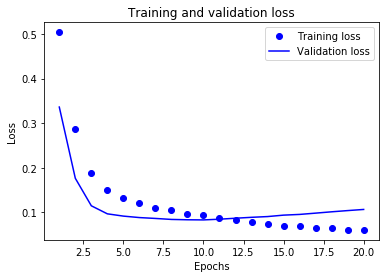

In [15]:
import matplotlib.pyplot as plt

accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs = range(1, len(history_dict['binary_accuracy']) + 1)
epochs = range(1, 21)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

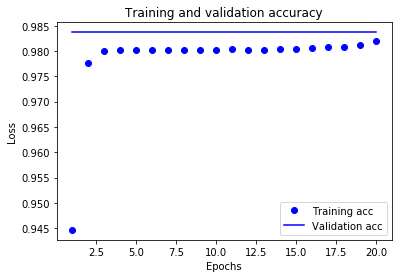

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDData_test.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')
texts_test  = df.loc[:,'FEDtext']
labels_test = df.loc[:,'FEDsize']
FEDid_test  = df.loc[:,'FEDid']
texts_test  = texts_test.values
labels_test = labels_test.values
FEDid_test  = FEDid_test.values

# ord laves til og der "paddes"
sequences_test = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test)

# One-hot training data
data_test = vectorize_sequences(data_test, dimension=max_words)

# labels laves til vektor
labels_test = np.asarray(labels_test).astype('float32')

In [12]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2

# print(predictions[1:20])

for i in range(1,20):
    print(('%1.4f' % predictions[i]))

[1.0839363e-18] [0.47580847]
0.0002
0.0012
0.0047
0.0000
0.0043
0.0038
0.0000
0.0288
0.0000
0.0000
0.0005
0.0046
0.0000
0.0080
0.0006
0.0035
0.0000
0.0221
0.0000


In [13]:
print('Antal store i datasættet:    ', sum(labels_test))

NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.01 and FEDid_test[i]<=493:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     113.0
antal estimeret af modellen:  55
Modellens præcision:          49.0 %


In [17]:
# jeg prøver at printe linjenummer, prediction og tekststreng

for i in range(1,6000):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   5  0.0043  Genopretning efter fjernstyringsfejlen på sjælland KYST
  16  0.0035  Holder nedbrudt i OH  MAteriel fra 2238
  28  0.0050  Fortsat spærret Lk - Es, nu til fredag kl 08:00
  99  0.0000  Fejl på tysk radio, vi kan ikke få fejl væk, trods flere forsøg, så der omdisponeres.
 205  0.3353  Nedformeringer fra sverige.
 247  0.0002  Står i stå i neutralsektion ilige før Ro Der skiftes strømaftager
 316  0.0001  Overgravet kabel. Standardprognose hvert i fald fem timer (fra kl. 11.00 hvor fejlsøgning startede).
 347  0.0250  kl 12:29 - Skinnebrud i sporskifte  Spor 2 i Middelfart er knækket, enkeltsporsdrift Kauslunde -
 382  0.1479  Nedformering fra Sverige
 478  0.0542  Nu kan der kun køres i et spor i Cph
 513  0.3175  Nedformeringer på kystbanen
 530  0.0001  Vi aflyser 4419 /4430 pga. mat kommer fra 4106 som holder bag L6 i Gl
 571  0.0049  Falsk besættelse Kk - Kn
 594  0.4265  Nedformeringer til og fra Sverige.
 622  0.0272  Overgravet kabel lige syd for Randers
 632  0.00